In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import time

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Conv2D, Input, MaxPool2D, Conv2DTranspose, concatenate, Lambda, BatchNormalization, Activation, LeakyReLU, ReLU
from keras.utils import img_to_array, load_img, plot_model
from keras.optimizers import Adam
from keras.initializers import RandomNormal

2024-06-12 08:56:49.752327: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 08:56:49.752439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 08:56:49.878500: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
annotation_folder = "/dataset/"
if not os.path.exists(os.path.abspath(".") + annotation_folder):
    annotation_zip = tf.keras.utils.get_file(
        "val.tar.gz",
        cache_subdir=os.path.abspath("."),
        origin="http://diode-dataset.s3.amazonaws.com/val.tar.gz",
        extract=True,
    )

2774625282/2774625282 ━━━━━━━━━━━━━━━━━━━━ 94s 0us/step


In [3]:
import os
import pandas as pd

data = {"image": [], "depth": [], "mask": []}
root_dir = "/kaggle/working/val"

for subdir in os.listdir(root_dir):
    subdir_path = os.path.join(root_dir, subdir)
    if os.path.isdir(subdir_path):
        for root, dirs, files in os.walk(subdir_path):
            for file in files:
                if file.endswith(".png"):
                    image_path = os.path.join(root, file)
                    depth_path = image_path.replace(".png", "_depth.npy")
                    mask_path = image_path.replace(".png", "_depth_mask.npy")

                    if os.path.exists(depth_path) and os.path.exists(mask_path):
                        data["image"].append(image_path)
                        data["depth"].append(depth_path)
                        data["mask"].append(mask_path)

df = pd.DataFrame(data)

In [4]:
HEIGHT = 256
WIDTH = 256


In [5]:
import cv2
import numpy as np

# Function to load and preprocess images
def load_and_preprocess_image(image_path, target_size=(HEIGHT, WIDTH)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
    img = cv2.resize(img, target_size)  # Resize image to target size
    img = img.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
    return img

# Function to load depth maps
def load_depth_map(depth_path, target_size=(HEIGHT, WIDTH)):
    depth_map = np.load(depth_path)
    depth_map = cv2.resize(depth_map, target_size)
    depth_map = depth_map.astype(np.float32)  # You may need additional preprocessing
    return depth_map

def load_mask(mask_path, depth_map, target_size=(HEIGHT, WIDTH)):
    mask = np.load(mask_path)
    mask = cv2.resize(mask, target_size)
    mask = mask > 0

    max_depth = min(300, np.percentile(depth_map, 99))
    depth_map = np.clip(depth_map, 0.1, max_depth)
    depth_map = np.log(depth_map, where=mask)

    depth_map = np.ma.masked_where(~mask, depth_map)

    depth_map = np.clip(depth_map, 0.1, np.log(max_depth))
    depth_map = np.expand_dims(depth_map, axis=2)

    return depth_map

# Load and preprocess the data
image_data = []
depth_data = []
for i in range(len(df)):
    image_data.append(load_and_preprocess_image(df['image'][i]))
    depth_map = load_depth_map(df['depth'][i])
    depth_data.append(load_mask(df['mask'][i], depth_map))

# Convert lists to NumPy arrays
x = np.array(image_data)
y = np.array(depth_data)

# Now, x contains your image data, and y contains your depth map data.

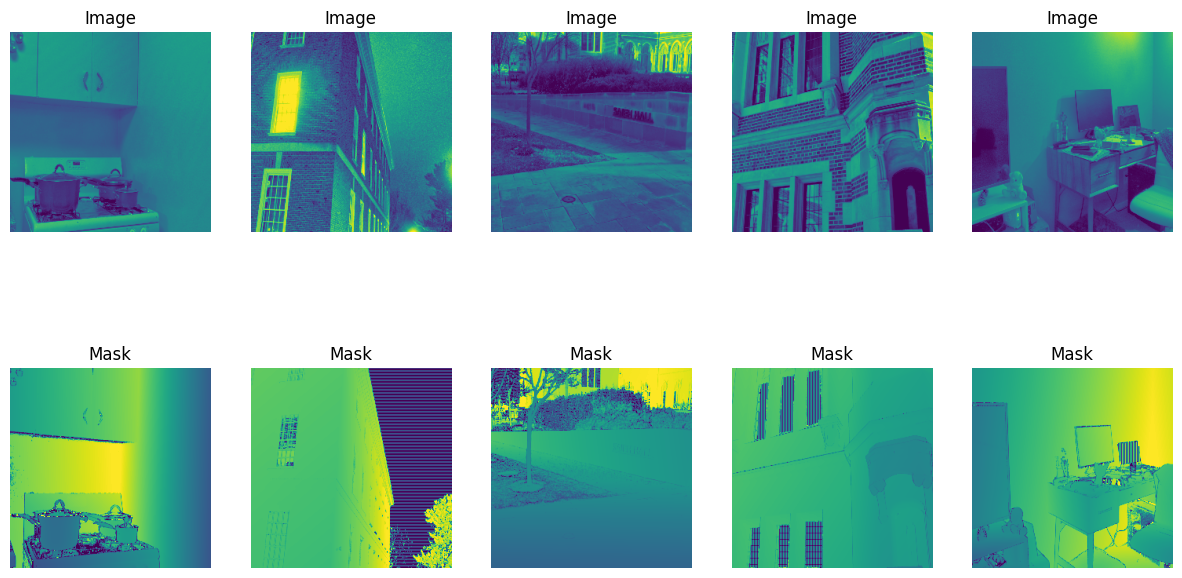

In [6]:
import random
import matplotlib.pyplot as plt

# Function to display images and masks
def display_random_images(images, masks, n=5):
    indices = random.sample(range(len(images)), n)
    plt.figure(figsize=(15, 8))
    for i, index in enumerate(indices):
        plt.subplot(2, n, i + 1)
        plt.imshow(images[index])
        plt.title('Image')
        plt.axis('off')
        
        plt.subplot(2, n, i + n + 1)
        plt.imshow(masks[index])
        plt.title('Mask')
        plt.axis('off')
    plt.show()

# Assuming x and y are numpy arrays of image and mask data
# Display 5 random images with masks
display_random_images(x, y, n=5)


In [7]:
y.shape

(771, 256, 256, 1)

In [8]:
x.shape

(771, 256, 256)

In [9]:
def downscale(num_filters):
    block = Sequential()
    block.add(Conv2D(num_filters, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    block.add(LeakyReLU(alpha=0.2))
    block.add(BatchNormalization())
    return block

def upscale(num_filters):
    block = Sequential()
    block.add(Conv2DTranspose(num_filters, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    block.add(LeakyReLU(alpha=0.2))
    block.add(BatchNormalization())
    block.add(ReLU())
    return block

def Generator():
    inputs = Input(shape=(256,256,1), name="InputLayer")

    encoder = [
        downscale(128),
        downscale(256),
        downscale(256),
        downscale(512),
        downscale(512),
        downscale(512),
        downscale(512),
    ]

    latent_space = downscale(512)

    decoder = [
        upscale(512),
        upscale(512),
        upscale(512),
        upscale(512),
        upscale(256),
        upscale(256),
        upscale(128),
    ]

    x = inputs
    skips = []
    for layer in encoder:
        x = layer(x)
        skips.append(x)

    x = latent_space(x)

    skips = reversed(skips)
    for up, skip in zip(decoder, skips):
        x = up(x)
        x = concatenate([x, skip])

    initializer = RandomNormal(stddev=0.02, seed=42)
    outputs = Conv2DTranspose(1, kernel_size=4, strides=2, kernel_initializer = initializer, activation = 'tanh', padding = 'same')

    outputs = outputs(x)

    generator = Model(inputs = inputs, outputs = outputs, name="Generator")
    return generator

In [10]:
generator = Generator()
plot_model(generator)
generator.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ InputLayer          │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      2,560 │ InputLayer[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    525,312 │ sequential[0][0]  │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │  1,049,600 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,099,200 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,196,352 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  4,196,352 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  4,196,352 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 1, 1, 512) │  4,196,352 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  4,196,352 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 512) │  8,390,656 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │  8,390,656 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_11[0]

 Total params: 57,177,089 (218.11 MB)

 Trainable params: 57,165,313 (218.07 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [11]:
#greyscale
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, LeakyReLU, BatchNormalization
from tensorflow.keras.initializers import RandomNormal

def Discriminator():
    image = Input(shape = (256,256,1), name = "ImageInput")
    target = Input(shape = (256,256,1), name = "TargetInput")
    x = concatenate([image, target])

    x = downscale(64)(x)
    x = downscale(512)(x)
    x = downscale(512)(x)

    initializer = RandomNormal(stddev = 0.02, seed=42)

    x = Conv2D(512, kernel_size = 4, strides = 1, kernel_initializer = initializer, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(1, kernel_size = 4, kernel_initializer = initializer)(x)

    discriminator = Model(inputs = [image, target], outputs = x, name = "Discriminator")

    return discriminator

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


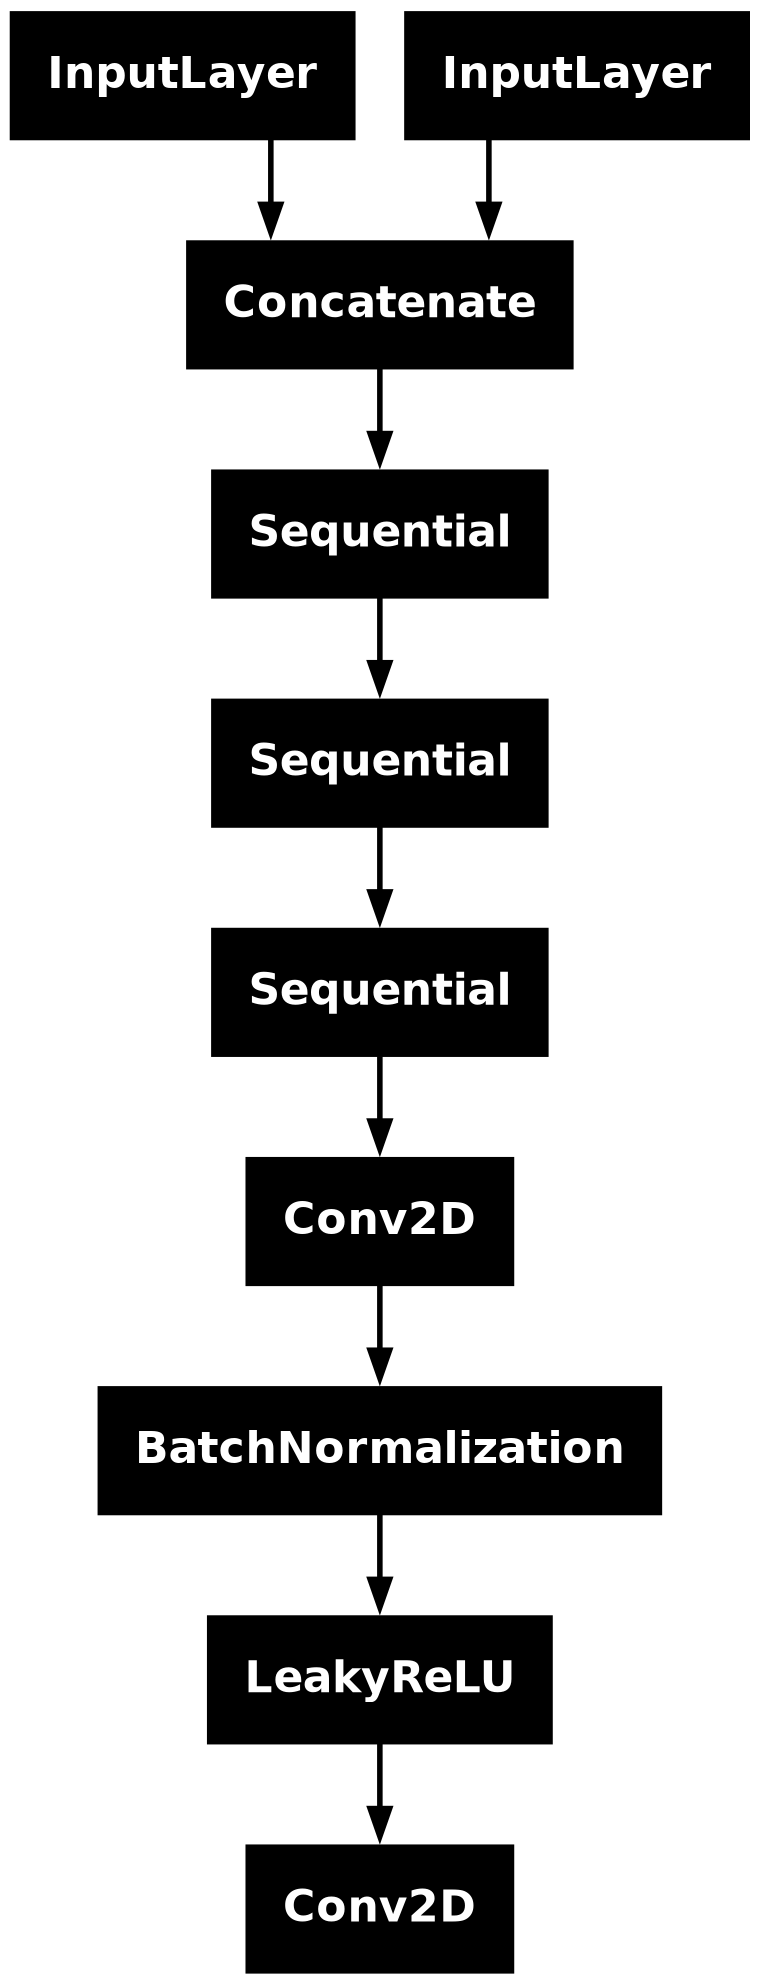

In [12]:
discriminator = Discriminator()
plot_model(discriminator)

In [13]:
adversarial_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.2)

def generator_loss(discriminator_generated, generated_output, target_image):
    gan_loss = adversarial_loss(tf.ones_like(discriminator_generated), discriminator_generated)
    l1_loss = tf.reduce_mean(tf.abs(target_image - generated_output))
    total_loss = (100 * l1_loss) + gan_loss
    return total_loss, gan_loss, l1_loss

def discriminator_loss(discriminator_real_output, discriminator_generated_output):
    real_loss = adversarial_loss(tf.ones_like(discriminator_real_output), discriminator_real_output)
    fake_loss = adversarial_loss(tf.zeros_like(discriminator_generated_output), discriminator_generated_output)
    total_loss = real_loss + fake_loss
    return total_loss
loss = [0,0,0,0]
def train_step(inputs, target):
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generated_output = generator(inputs, training=True)

        discriminator_real_output = discriminator([inputs, target], training=True)
        discriminator_generated_output = discriminator([inputs, generated_output], training=True)

        generator_total_loss, generator_gan_loss, generator_l1_loss = generator_loss(discriminator_generated_output, generated_output, target)
        discriminator_Loss = discriminator_loss(discriminator_real_output, discriminator_generated_output)
    
    generator_gradients = generator_tape.gradient(generator_total_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

    discriminator_gradients = discriminator_tape.gradient(discriminator_Loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
    # Calculate average losses
    generator_total_loss_avg = tf.reduce_mean(generator_total_loss)
    generator_gan_loss_avg = tf.reduce_mean(generator_gan_loss)
    generator_l1_loss_avg = tf.reduce_mean(generator_l1_loss)
    discriminator_loss_avg = tf.reduce_mean(discriminator_Loss)
    
    loss[0] = generator_total_loss_avg.numpy()
    loss[1] = generator_gan_loss_avg.numpy()
    loss[2] = generator_l1_loss_avg.numpy()
    loss[3] = discriminator_loss_avg.numpy()
    return loss


In [14]:
def fit(data, epochs):
  for epoch in range(epochs):
    start = time.time()
    print("Current epoch: ", epoch+1)
    for image, mask in data:
      loss_gen = train_step(image, mask)
    print(loss_gen)
    print(f"Time taken to complete the epoch {epoch + 1} is {(time.time() - start):.2f} seconds \n")

In [15]:
input_image, target_image = tf.cast(x, tf.float32), tf.cast(y, tf.float32)
dataset = (input_image,target_image)
data = tf.data.Dataset.from_tensor_slices(dataset).batch(32, drop_remainder=True)

In [16]:
fit(data, 800)

Current epoch:  1
[148.16881, 0.9876507, 1.4718115, 1.2013497]
Time taken to complete the epoch 1 is 63.26 seconds 

Current epoch:  2
[142.12392, 1.5145475, 1.4060937, 0.8154241]
Time taken to complete the epoch 2 is 42.71 seconds 

Current epoch:  3
[140.20609, 2.6340234, 1.3757207, 0.2678145]
Time taken to complete the epoch 3 is 42.83 seconds 

Current epoch:  4
[139.32445, 3.3418002, 1.3598266, 0.13777089]
Time taken to complete the epoch 4 is 42.86 seconds 

Current epoch:  5
[139.06953, 3.496641, 1.3557289, 0.09587066]
Time taken to complete the epoch 5 is 42.85 seconds 

Current epoch:  6
[138.43985, 2.927637, 1.3551221, 0.118754506]
Time taken to complete the epoch 6 is 42.88 seconds 

Current epoch:  7
[137.50957, 3.875153, 1.3363441, 0.061369754]
Time taken to complete the epoch 7 is 42.79 seconds 

Current epoch:  8
[138.8858, 4.707776, 1.3417802, 0.04012088]
Time taken to complete the epoch 8 is 42.84 seconds 

Current epoch:  9
[136.50188, 4.671625, 1.3183025, 0.036693137

In [17]:
def show_predictions(num_samples):
    for i in range(num_samples):
        idx = np.random.randint(x.shape[0])
        image, mask = x[idx], y[idx]
        predicted = generator.predict(tf.expand_dims(image, axis=0))[0]

        plt.figure(figsize=(10,8))

        plt.subplot(1,3,1)
        plt.imshow(image)
        plt.title("Satellite Image " + str(i + 1))
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(mask)
        plt.title("Map Image " + str(i + 1))
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(predicted)
        plt.title("Predicted Image " + str(i + 1))
        plt.axis('off')

        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1718217068.498571      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


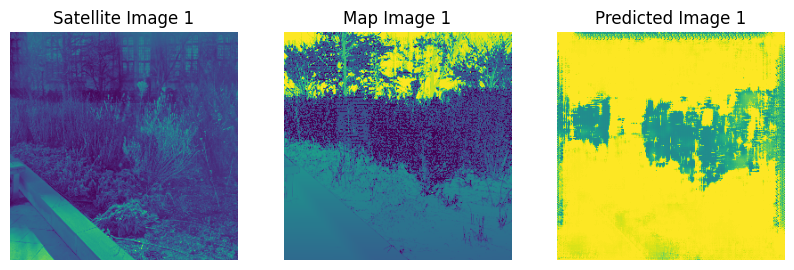

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


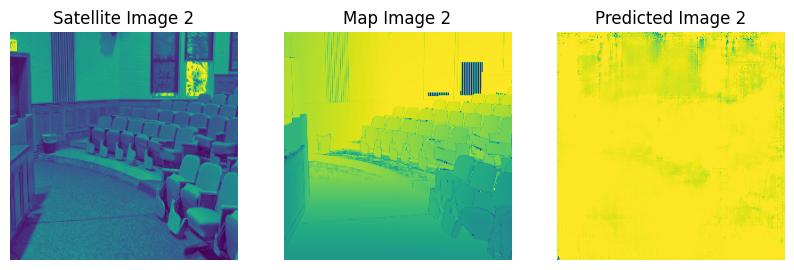

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


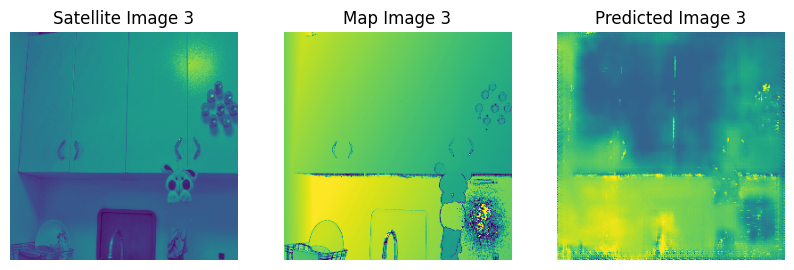

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


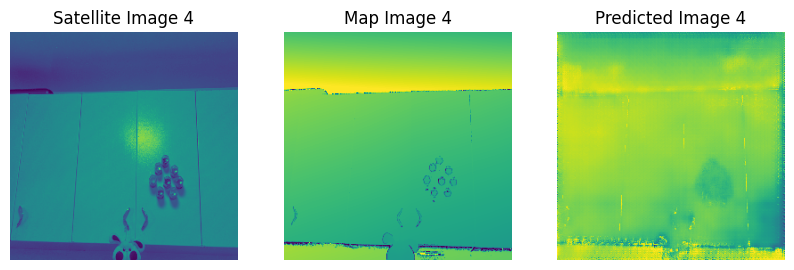

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


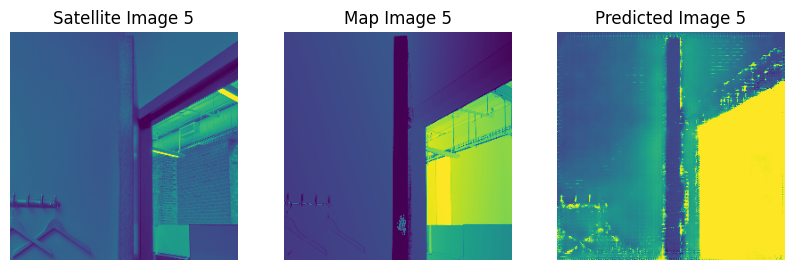

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


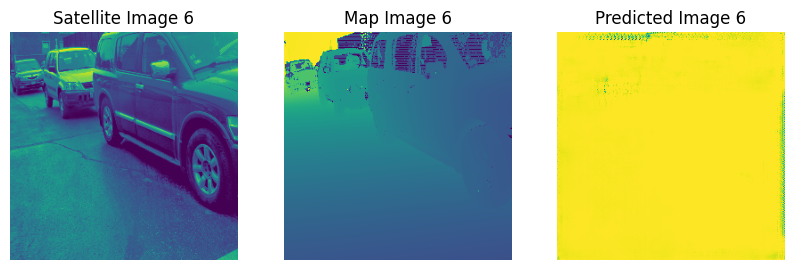

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


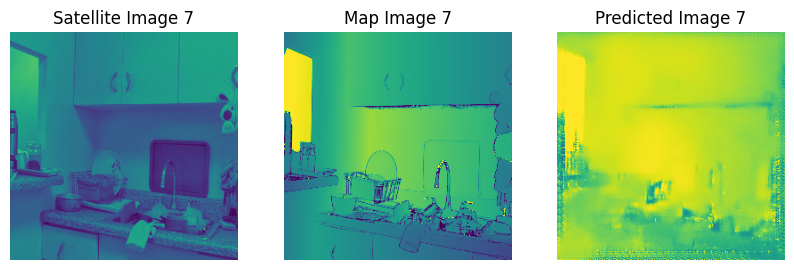

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


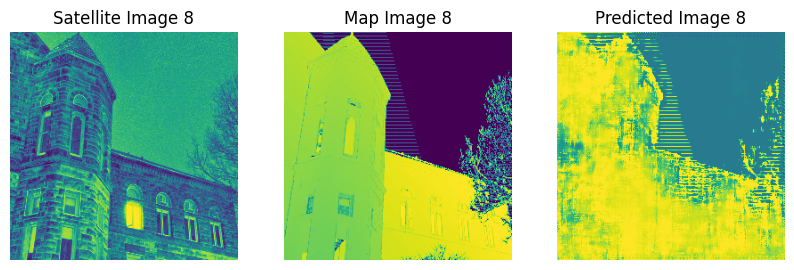

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


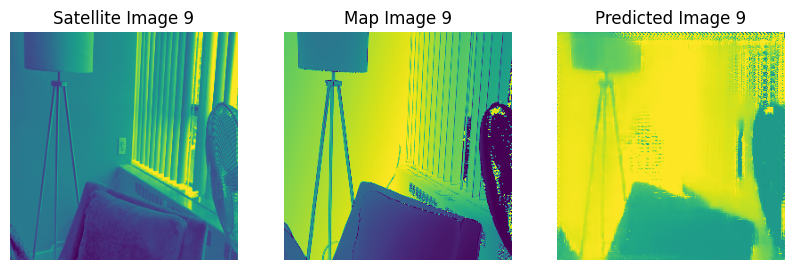

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


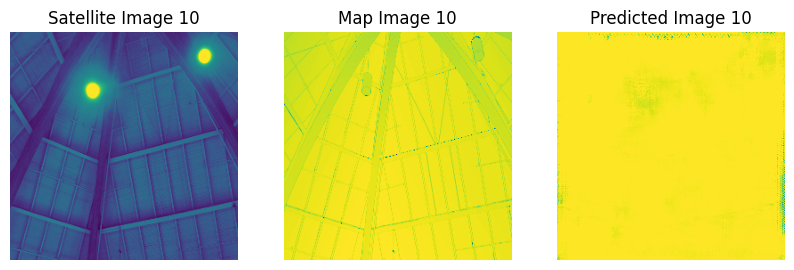

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


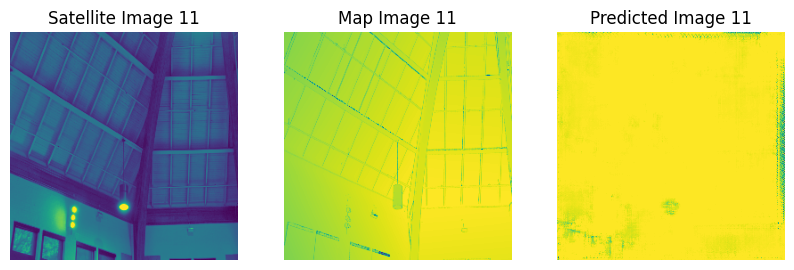

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


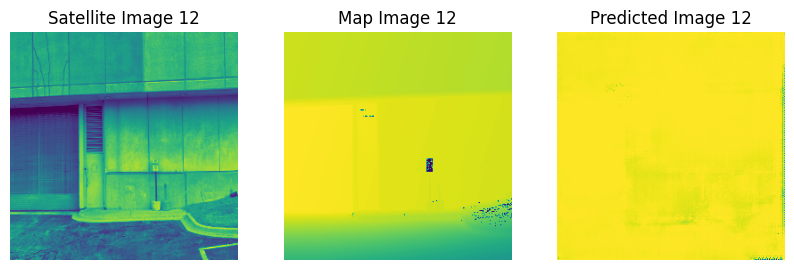

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


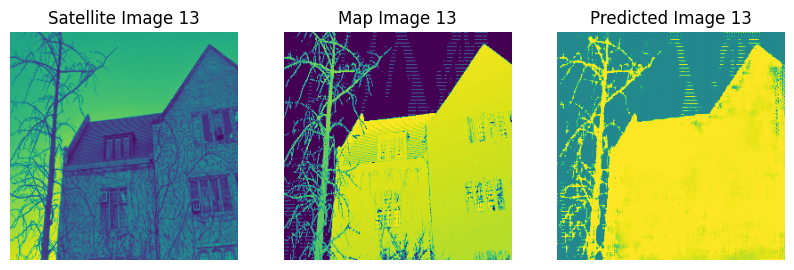

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


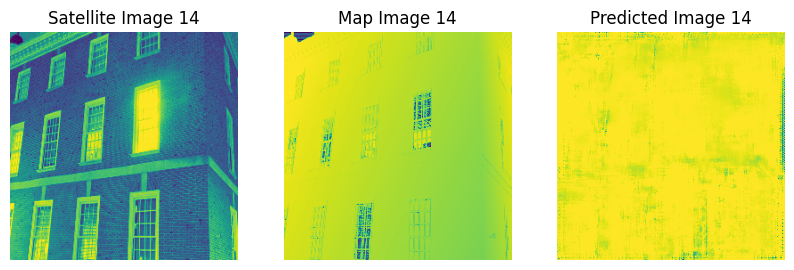

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


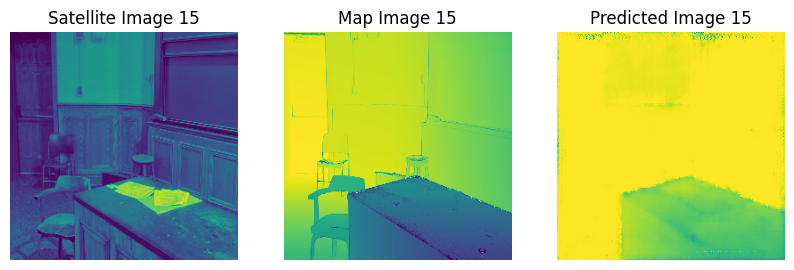

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


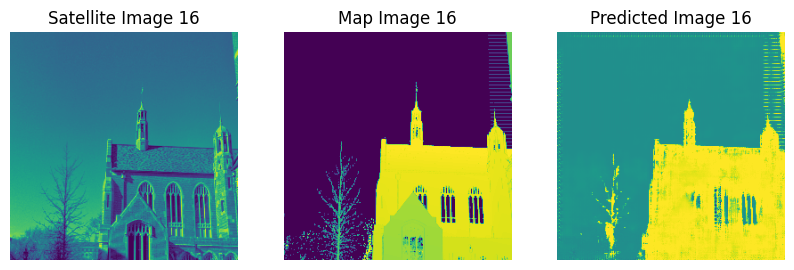

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


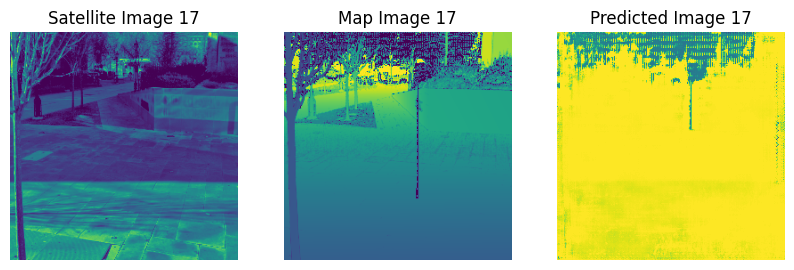

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


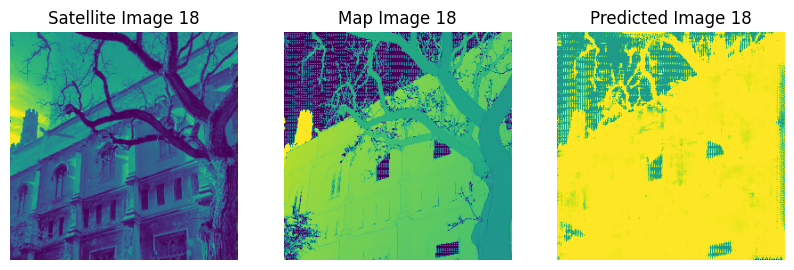

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


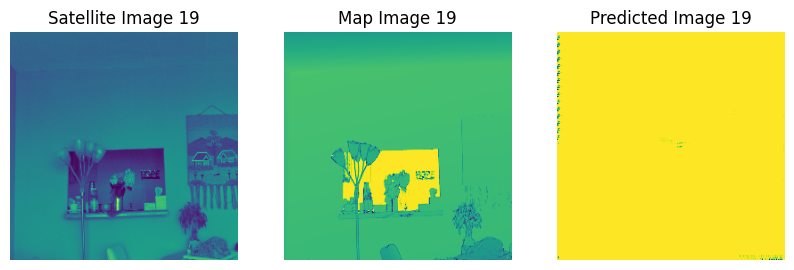

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


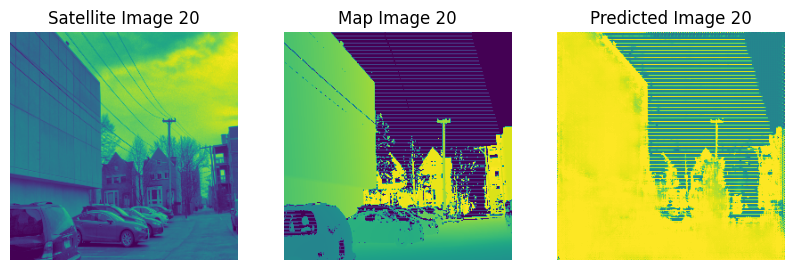

In [18]:
show_predictions(20)

In [19]:
generator.save("depthpridiction_monocolour_400.keras")